# MassiveMIMO CSI Dataset for AI

## Introduction
This notebook explores a dataset generated for Massive MIMO CSI analysis in 5G scenarios. We perform data preprocessing, visualization, machine learning, and deep learning tasks to demonstrate the utility of the dataset. The key objectives are:

1. Analyze and summarize CSI data.
2. Perform SNR classification.
3. Predict CSI magnitudes.
4. Detect anomalies in CSI data using advanced techniques.

In [4]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.keras import TqdmCallback

import os
import requests
from tqdm import tqdm

#### Data Download
This cell checks if the `csi_data_massive_mimo.mat` file is present in the current directory. If the file is missing, it automatically downloads it from the specified Zenodo URL. This ensures that the dataset is available for use before proceeding with further analysis in the notebook.


In [5]:
file_name = "csi_data_massive_mimo.mat"
zenodo_url = "https://zenodo.org/record/14555910/files/csi_data_massive_mimo.mat"  

# Function to download the file with a progress bar
def download_with_progress(url, file_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte
    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc="Downloading")

    with open(file_path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

    if total_size != 0 and progress_bar.n != total_size:
        print("ERROR: Download incomplete!")
    else:
        print(f"Dataset downloaded successfully as '{file_path}'.")

# Check if the file exists
if not os.path.isfile(file_name):
    print(f"Dataset file '{file_name}' not found in the current directory.")
    print("Downloading the dataset from Zenodo...")
    try:
        download_with_progress(zenodo_url, file_name)
    except Exception as e:
        print(f"An error occurred while downloading the dataset: {e}")
else:
    print(f"Dataset file '{file_name}' is already present in the current directory.")

Dataset file 'csi_data_massive_mimo.mat' not found in the current directory.


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.50G/1.50G [06:44<00:00, 3.71MiB/s]

Dataset downloaded successfully as 'csi_data_massive_mimo.mat'.


#### Data Loading
We begin by loading the dataset saved in MATLAB `.mat` format. The data is structured as a multi-dimensional array containing Channel State Information (CSI) for different cells, UEs, and scenarios.

- `multi_cell_csi`: A nested cell array containing CSI for 10 cells, 200 UEs per cell, and 3 scenarios: Stationary, High-Speed, and Urban Macrocell.


In [2]:
# Load the MATLAB dataset
data = sio.loadmat('foundation_model_data/csi_data_massive_mimo.mat')
multi_cell_csi = data['multi_cell_csi']

#### Data Preprocessing
We calculate summary statistics for the CSI dataset:

1. **Average CSI Magnitude**: Aggregates the absolute values of CSI data to capture signal strength.
2. **SNR Statistics**: Computes the mean and standard deviation of Signal-to-Noise Ratio (SNR) across subcarriers.
3. The results are stored for each scenario, and the data is converted into a tabular format for further analysis.

Functions used:
- `calculate_avg_csi_magnitude`: Computes the average CSI magnitude for all subcarriers.
- `calculate_snr_statistics`: Calculates mean and standard deviation of SNR values.


In [3]:
# Extract data from the MATLAB cell structure
num_cells = multi_cell_csi.shape[0]
num_ues = multi_cell_csi.shape[1]
scenarios = ['Stationary', 'High-Speed', 'Urban Macrocell']

In [4]:
# Function to calculate average CSI magnitude per subcarrier
def calculate_avg_csi_magnitude(csi_data):
    return np.mean(np.abs(csi_data), axis=(1, 2))

# Function to calculate SNR statistics
def calculate_snr_statistics(csi_data):
    snr_per_subcarrier = 10 * np.log10(np.mean(np.abs(csi_data) ** 2, axis=(1, 2)))
    return snr_per_subcarrier.mean(), snr_per_subcarrier.std()

#### Data Summarization
Using the preprocessed data, we create:
- **Table 1**: Summary of mean SNR and its standard deviation for each scenario.
- **Sample Table**: A random subset of the SNR statistics for inspection.

This provides insights into the differences between scenarios and helps in setting up machine learning tasks.


In [5]:
# Initialize dictionaries for storing results
avg_csi_all_scenarios = {scenario: [] for scenario in scenarios}
snr_stats_all_scenarios = []

# Analyze and process the dataset
for cell_idx in range(num_cells):
    for ue_idx in range(num_ues):
        csi_scenarios = multi_cell_csi[cell_idx, ue_idx][0]
        for scenario_idx, scenario_name in enumerate(scenarios):
            csi_data = csi_scenarios[scenario_idx]
            avg_csi_all_scenarios[scenario_name].append(calculate_avg_csi_magnitude(csi_data))
            mean_snr, std_snr = calculate_snr_statistics(csi_data)
            snr_stats_all_scenarios.append({
                'Cell': cell_idx + 1,
                'UE': ue_idx + 1,
                'Scenario': scenario_name,
                'Mean SNR (dB)': mean_snr,
                'SNR Std Dev (dB)': std_snr,
            })

# Convert SNR statistics to a DataFrame
snr_stats_df = pd.DataFrame(snr_stats_all_scenarios)

In [6]:
snr_stats_df.sample(10)

,Cell,UE,Scenario,Mean SNR (dB),SNR Std Dev (dB)
289,1,97,High-Speed,-5.968823,0.138822
379,1,127,High-Speed,-5.974855,0.138739
5040,9,81,Stationary,-5.938675,0.085248
2872,5,158,High-Speed,-5.976039,0.146410
2193,4,132,Stationary,-5.939034,0.085935
2026,4,76,High-Speed,-5.974029,0.136437
2531,5,44,Urban Macrocell,-6.143595,0.075160
2953,5,185,High-Speed,-5.973531,0.135885
417,1,140,Stationary,-5.937757,0.089218
4218,8,7,Stationary,-5.933113,0.091176


In [7]:
# Table 1: SNR Summary by Scenario
snr_stats_table = snr_stats_df.groupby('Scenario').agg(
    Mean_SNR=('Mean SNR (dB)', 'mean'),
    SNR_Std=('SNR Std Dev (dB)', 'mean')
).reset_index()
print("Table 1: SNR Summary by Scenario")
snr_stats_table

Table 1: SNR Summary by Scenario


,Scenario,Mean_SNR,SNR_Std
0,High-Speed,-5.972012,0.136974
1,Stationary,-5.940888,0.089276
2,Urban Macrocell,-6.145050,0.074185


#### Visualization
To better understand the dataset, we generate the following plots:
1. **Average CSI Magnitude Across Subcarriers**:
   - Visualizes the mean CSI magnitude for all scenarios over subcarriers.
2. **SNR Distribution**:
   - Displays histograms of SNR values for each scenario.
3. **Boxplot of Mean SNR**:
   - Compares the distribution of SNR means across scenarios.

These visualizations reveal differences in signal strength and variability between scenarios.


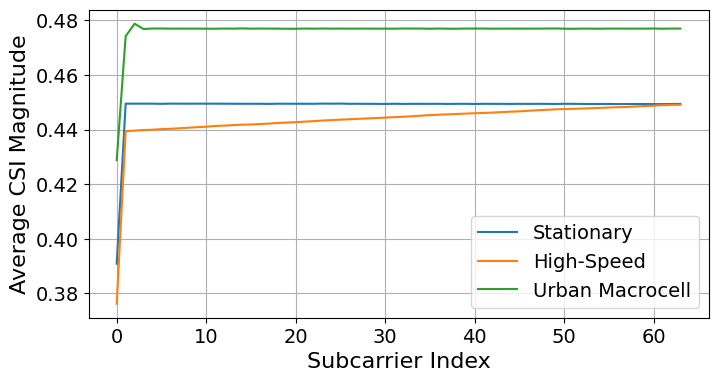

In [8]:
# Visualization 1: Average CSI Magnitude by Subcarrier
plt.figure(figsize=(8, 4))
for scenario_name in scenarios:
    avg_csi = np.mean(avg_csi_all_scenarios[scenario_name], axis=0)
    plt.plot(avg_csi, label=scenario_name)

#plt.title("Average CSI Magnitude Across Subcarriers (All Scenarios)")
plt.xlabel("Subcarrier Index", fontsize=16)
plt.ylabel("Average CSI Magnitude", fontsize=16)
# Increase the font size of ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.savefig('average_csi_magnitude_by_subcarrier_scenarios.pdf', bbox_inches='tight')
plt.show()

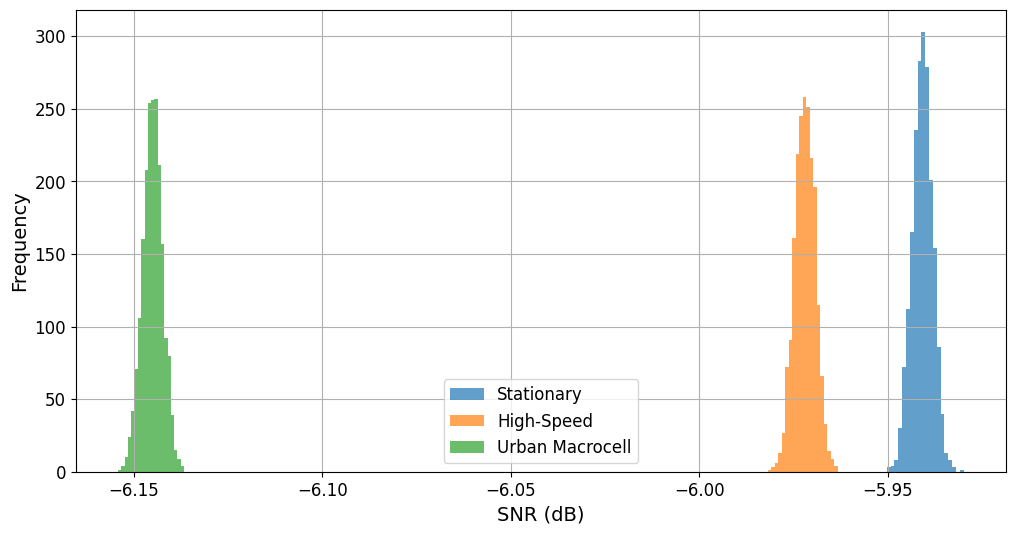

In [9]:
plt.figure(figsize=(12, 6))
for scenario_name in scenarios:
    snr_means = snr_stats_df[snr_stats_df['Scenario'] == scenario_name]['Mean SNR (dB)']
    plt.hist(snr_means, bins=20, alpha=0.7, label=scenario_name)

# plt.title("SNR Distribution by Scenario", fontsize=16)
plt.xlabel("SNR (dB)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Increase tick label fonts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Increase legend font
plt.legend(fontsize=12)

plt.grid()

# Save as PDF
plt.savefig("snr_distribution_by_scenario.pdf", bbox_inches='tight')
plt.show()


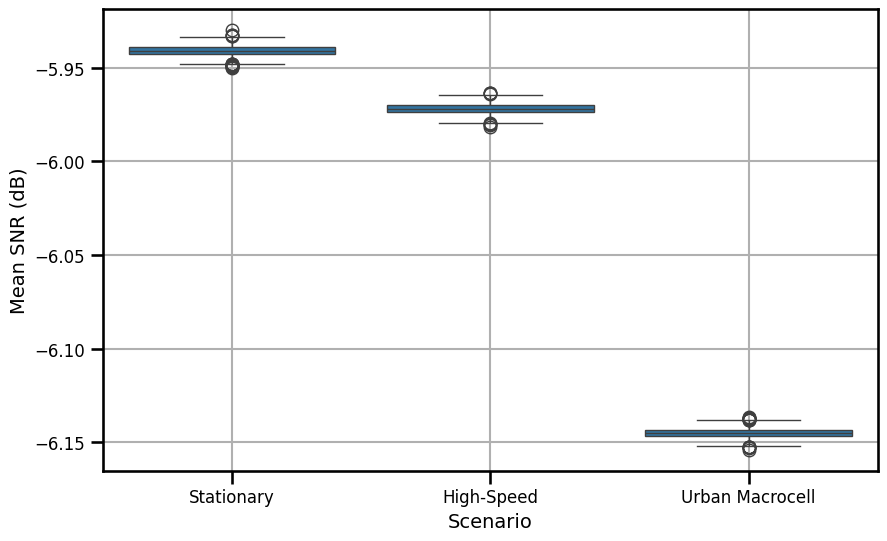

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optionally, set a context for consistent font sizes across all plots
sns.set_context("talk", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.boxplot(data=snr_stats_df, x='Scenario', y='Mean SNR (dB)')

# plt.title("Boxplot of Mean SNR Across Scenarios", fontsize=16)
plt.xlabel("Scenario", fontsize=14)
plt.ylabel("Mean SNR (dB)", fontsize=14)

# Adjust tick label font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid()

# Save as PDF
plt.savefig("boxplot_mean_snr_scenarios.pdf", bbox_inches='tight')

plt.show()


#### Machine Learning: CSI Magnitude Prediction
Using the stationary scenario data:
1. Predict the CSI magnitude of the last subcarrier based on previous subcarriers.
2. Train a Random Forest regressor to predict the target values.
3. Evaluate the model using Mean Squared Error (MSE).
4. Visualize predictions vs. true values for the first 50 test samples.

This task demonstrates how machine learning models can be used to infer missing or corrupted data.


CSI Magnitude Prediction MSE: 0.0000


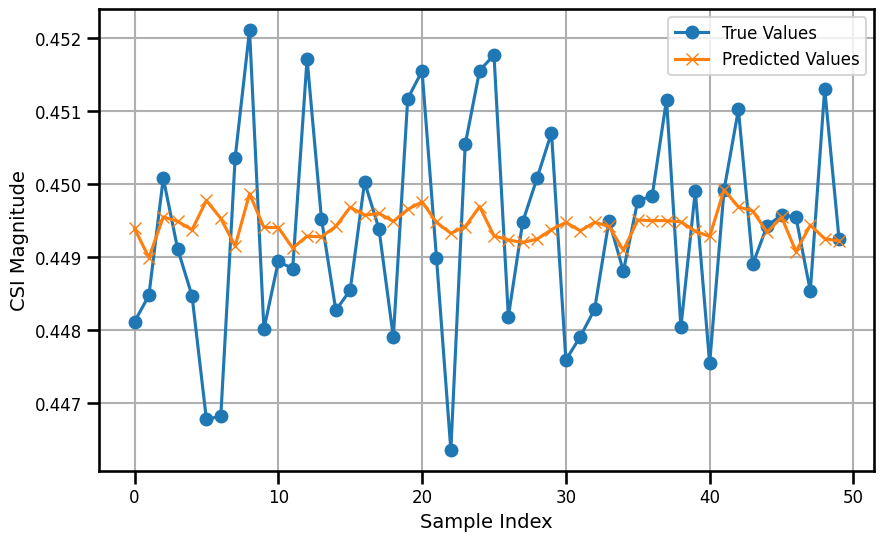

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Prepare data for CSI magnitude prediction
scenario_name = 'Stationary'  # Example scenario
avg_csi_data = np.array(avg_csi_all_scenarios[scenario_name])  # Extract preprocessed data

# Use previous subcarriers' CSI values as features and predict the next subcarrier
X = avg_csi_data[:, :-1]  # All subcarriers except the last
y = avg_csi_data[:, -1]   # The last subcarrier as the target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"CSI Magnitude Prediction MSE: {mse:.4f}")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test[:50], label='True Values', marker='o')
plt.plot(y_pred[:50], label='Predicted Values', marker='x')

# plt.title("CSI Magnitude Prediction (First 50 Samples)", fontsize=16)
plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("CSI Magnitude", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)
plt.grid()

# Save as PDF
plt.savefig("csi_magnitude_prediction_first_50_samples.pdf", bbox_inches='tight')

plt.show()


#### Machine Learning: SNR Classification
This task involves:
1. Encoding scenario labels into numerical categories.
2. Training a Random Forest classifier using `Mean SNR` and `SNR Std Dev` as features.
3. Evaluating the model with precision, recall, F1-score, and accuracy metrics.
4. Visualizing results with a confusion matrix.

This showcases how the dataset can be used for scenario classification based on signal quality metrics.


Classification Report:
                 precision    recall  f1-score   support

     High-Speed       1.00      1.00      1.00       422
     Stationary       1.00      1.00      1.00       375
Urban Macrocell       1.00      1.00      1.00       403

       accuracy                           1.00      1200
      macro avg       1.00      1.00      1.00      1200
   weighted avg       1.00      1.00      1.00      1200



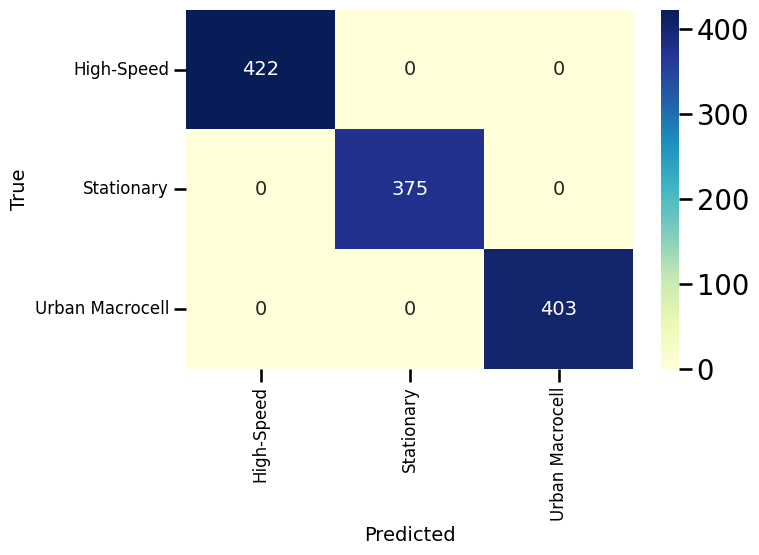

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prepare data for SNR classification
X = snr_stats_df[['Mean SNR (dB)', 'SNR Std Dev (dB)']].values  # Features
y = snr_stats_df['Scenario']  # Labels

# Encode scenario labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Evaluate the model
y_pred = classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

# Increase annotation size using annot_kws
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            annot_kws={"fontsize":14})

# plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

# Increase tick label font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)  # rotation=0 to keep y-labels horizontal

plt.tight_layout()

# Save as PDF
plt.savefig("confusion_matrix.pdf", bbox_inches='tight')

plt.show()

#### Anomaly Detection Using Isolation Forest
For the Urban Macrocell scenario:
1. Train an Isolation Forest model to detect anomalies in CSI magnitude.
2. Identify anomalies based on reconstruction errors exceeding a threshold (e.g., 95th percentile).
3. Visualize the anomalies using scatter plots.

This approach helps identify unusual patterns in CSI data, potentially due to interference or equipment issues.


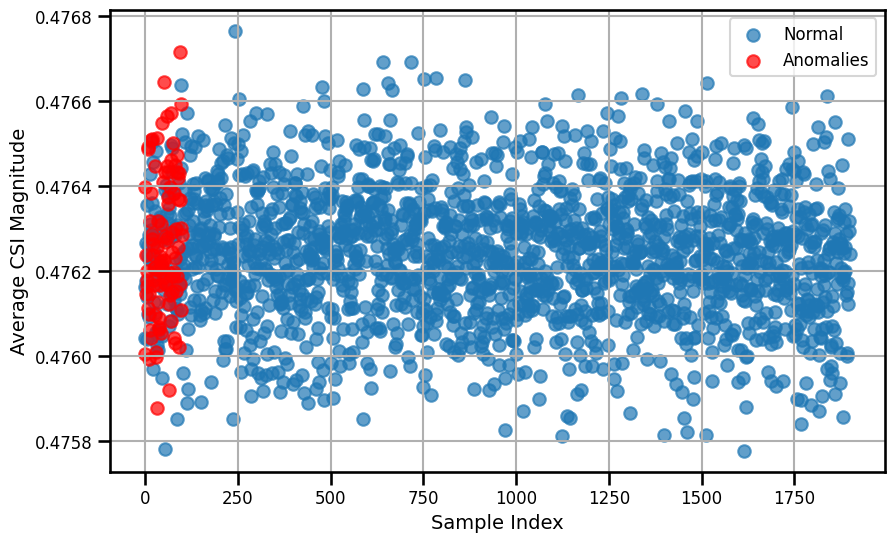

Number of anomalies detected: 100


In [13]:
from sklearn.ensemble import IsolationForest

# Prepare data for anomaly detection (using average CSI magnitudes)
scenario_name = 'Urban Macrocell'
avg_csi_data = np.array(avg_csi_all_scenarios[scenario_name])

# Flatten data for anomaly detection
X = avg_csi_data.reshape(avg_csi_data.shape[0], -1)

# Train an Isolation Forest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
anomaly_scores = isolation_forest.fit_predict(X)

# Visualize anomalies
anomalies = X[anomaly_scores == -1]
normal_data = X[anomaly_scores == 1]

plt.figure(figsize=(10, 6))

plt.scatter(range(len(normal_data)), np.mean(normal_data, axis=1), label='Normal', alpha=0.7)
plt.scatter(range(len(anomalies)), np.mean(anomalies, axis=1), label='Anomalies', color='red', alpha=0.7)

# plt.title("Anomaly Detection in CSI Magnitudes", fontsize=16)
plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("Average CSI Magnitude", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)
plt.grid()

# Save as PDF
plt.savefig("anomaly_detection_csi_magnitudes.pdf", bbox_inches='tight')

plt.show()


print(f"Number of anomalies detected: {len(anomalies)}")


#### Deep Learning: Neural Network for SNR Classification
We train a fully connected neural network to classify scenarios:
1. Input: `Mean SNR` and `SNR Std Dev`.
2. Architecture:
   - Input layer.
   - Two hidden layers with ReLU activations and dropout for regularization.
   - Output layer with softmax activation.
3. Evaluate performance using accuracy, confusion matrix, and classification report.
4. Visualize training and validation accuracy over epochs.

This demonstrates the power of deep learning for classification tasks in this dataset.


/Users/ozgur/miniforge3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Test Accuracy: 1.0000


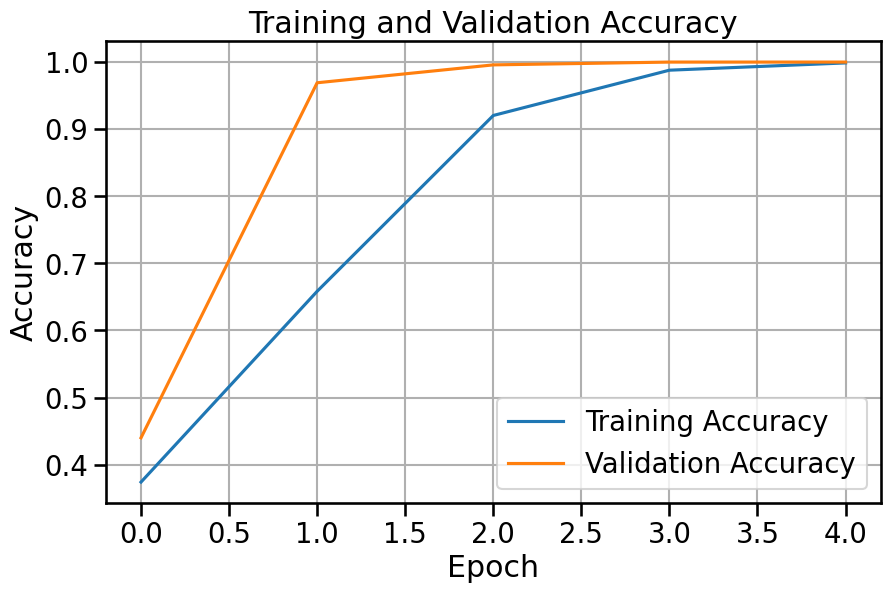

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
                 precision    recall  f1-score   support

     High-Speed       1.00      1.00      1.00       422
     Stationary       1.00      1.00      1.00       375
Urban Macrocell       1.00      1.00      1.00       403

       accuracy                           1.00      1200
      macro avg       1.00      1.00      1.00      1200
   weighted avg       1.00      1.00      1.00      1200



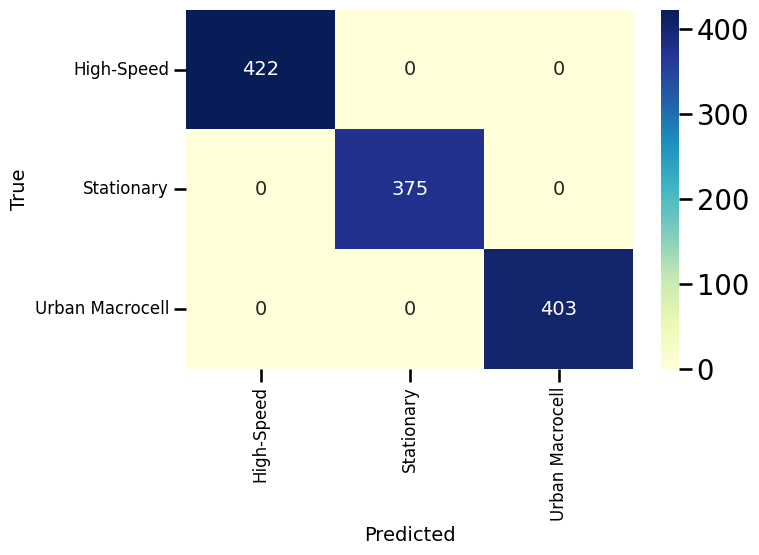

In [14]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
X = snr_stats_df[['Mean SNR (dB)', 'SNR Std Dev (dB)']].values  # Features
y = snr_stats_df['Scenario']  # Labels

# Encode scenario labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_onehot, 
                    validation_data=(X_test, y_test_onehot),
                    epochs=5, 
                    batch_size=256, 
                    verbose=0, callbacks=[TqdmCallback(verbose=1)])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cmap="YlGnBu", annot_kws={"fontsize":14})
# plt.title("Confusion Matrix")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

# Increase tick label font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)  # rotation=0 to keep y-labels horizontal

plt.tight_layout()

plt.savefig("nn_confusion_matrix.pdf", bbox_inches='tight')


plt.show()


#### Deep Learning: Autoencoder for Anomaly Detection
We use an autoencoder to detect anomalies in the stationary scenario:
1. Input: Flattened and normalized CSI magnitudes.
2. Architecture:
   - Encoder: Reduces input dimensionality step by step.
   - Decoder: Reconstructs input from the encoded representation.
3. Evaluate reconstruction loss for test data.
4. Detect anomalies based on reconstruction errors exceeding a threshold.
5. Visualize reconstruction errors and anomalies.

This task showcases how deep learning can model normal data patterns and identify deviations.


/Users/ozgur/miniforge3/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

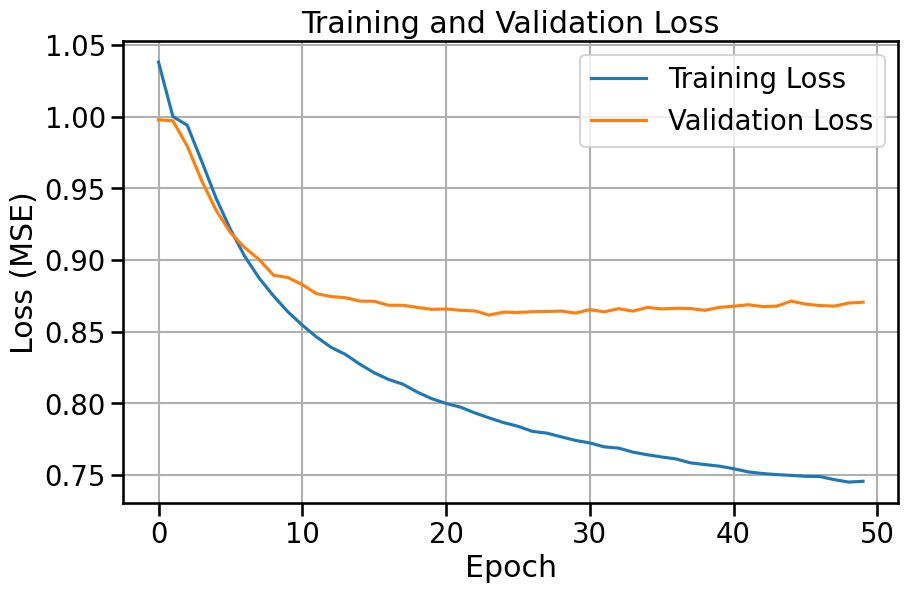

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


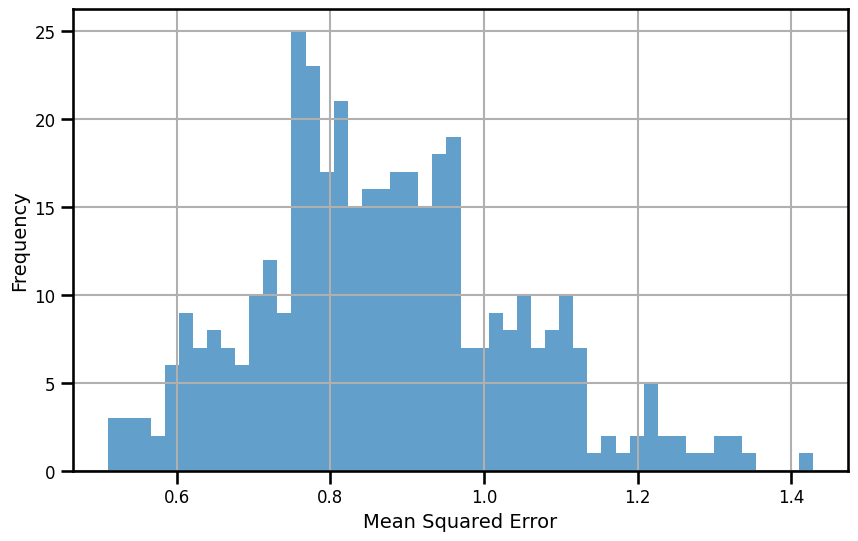

Number of anomalies detected: 20


In [15]:
# Prepare data for the autoencoder
scenario_name = 'Stationary'  # Example scenario
avg_csi_data = np.array(avg_csi_all_scenarios[scenario_name])  # Extract data

# Flatten CSI data for input to the autoencoder
X = avg_csi_data.reshape(avg_csi_data.shape[0], -1)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Define the autoencoder architecture
input_dim = X_train.shape[1]

autoencoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_dim,)),
    tf.keras.layers.Dense(128, activation='relu'),  # Encoder
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),  # Decoder
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='sigmoid')  # Output layer
])

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, 
                          validation_data=(X_test, X_test),
                          epochs=50, 
                          batch_size=16, 
                          verbose=0, callbacks=[TqdmCallback(verbose=1)])

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

# Reconstruct data and calculate reconstruction errors
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean((X_test - X_test_reconstructed) ** 2, axis=1)

# Visualize reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.7)

#plt.title("Reconstruction Errors", fontsize=16)
plt.xlabel("Mean Squared Error", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid()

# Save as PDF
plt.savefig("reconstruction_errors_hist.pdf", bbox_inches='tight')

plt.show()

# Anomaly detection based on reconstruction error threshold
threshold = np.percentile(reconstruction_errors, 95)  # Set threshold at 95th percentile
anomalies = reconstruction_errors > threshold

print(f"Number of anomalies detected: {np.sum(anomalies)}")


#### Conclusion
This notebook demonstrates various ways to analyze and model Massive MIMO CSI data:
1. Visualizing and summarizing CSI and SNR metrics.
2. Applying machine learning for prediction and classification.
3. Using anomaly detection techniques to identify outliers.
4. Leveraging deep learning models for advanced tasks.

These examples illustrate the versatility and value of this dataset for wireless communication research.
